# Statistik-Projekt HS25 – A/B-Testing & Effektgrößen
## Notebook 9: Zürich HB vs. St. Gallen – Vergleich der Ankunftsverspätungen

### Ziel
Wir untersuchen, ob Züge am **Zürich Hauptbahnhof (ZH HB)** systematisch höhere Verspätungen aufweisen als am **Bahnhof St. Gallen (SG)**.

### Fragen:
1. Gibt es einen statistisch signifikanten Unterschied in den Verspätungen?
2. Wie groß ist der Unterschied (Effektgröße)?
3. Können wir den Unterschied mittels **Bootstrap-Konfidenzintervallen** quantifizieren?
4. Ist der Unterschied im echten Betrieb relevant?

### Methoden:
- Zweistichproben-Vergleich:
  - **Welch’s t-Test** (robust gegenüber ungleichen Varianzen)
  - **Mann–Whitney-U-Test** (nichtparametrisch)
- **Effektgrößen**:
  - Cohen’s d
  - Rank-biserial correlation
- **Bootstrap (10'000 Samples)** für:
  - Unterschied der Mittelwerte
  - Unterschied der Mediane


## Imports und Daten laden

In [2]:
import polars as pl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

DATA_PATH = "../data/processed/istdata_clean.parquet"

df = pl.read_parquet(DATA_PATH)

df = (
    df
    .select(["HALTESTELLEN_NAME", "delay_arrival_s"])
    .with_columns((pl.col("delay_arrival_s") / 60).alias("delay_min"))
    .drop_nulls()
)

# Zwei Bahnhöfe auswählen
df_ab = df.filter(
    pl.col("HALTESTELLEN_NAME").is_in(["Zürich HB", "St. Gallen"])
)

df_ab = df_ab.to_pandas()  # Wir brauchen pandas für die Stats-Modelle

df_ab.head()

,HALTESTELLEN_NAME,delay_arrival_s,delay_min
0,Zürich HB,257.0,4.283333
1,Zürich HB,12.0,0.200000
2,Zürich HB,106.0,1.766667
3,Zürich HB,80.0,1.333333
4,Zürich HB,203.0,3.383333


## Basis-Werte

In [4]:
df_ab.groupby("HALTESTELLEN_NAME")["delay_min"].describe()

,count,mean,std,min,25%,50%,75%,max
HALTESTELLEN_NAME,,,,,,,,
St. Gallen,14963.0,0.857839,3.415296,-55.783333,-0.416667,0.466667,1.450000,73.916667
Zürich HB,51695.0,1.161590,4.074215,-30.066667,0.033333,0.566667,1.383333,267.500000


## Visualisierung der Verteilungen

/var/folders/nr/v5m21pks103fpq8ld3fn_0y80000gn/T/ipykernel_62827/1175069380.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_ab, x="HALTESTELLEN_NAME", y="delay_min", palette="viridis")


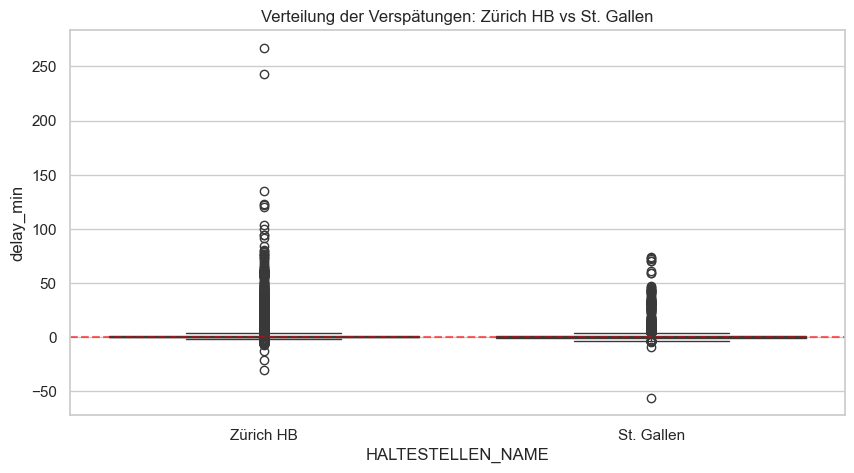

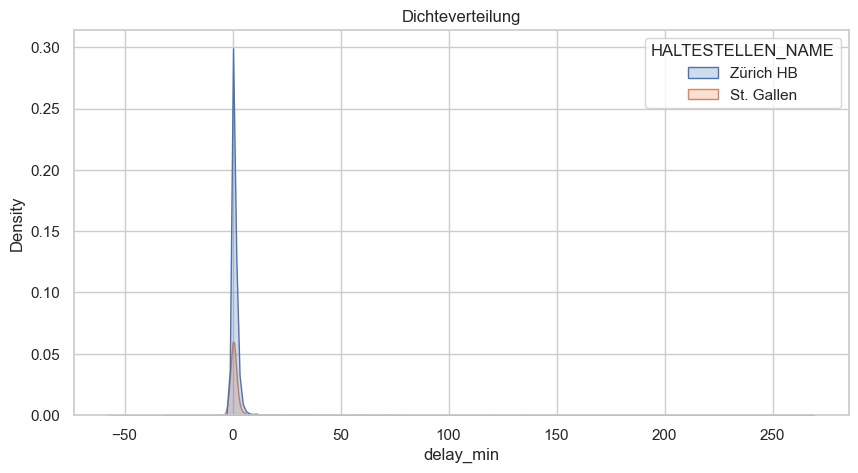

In [6]:
sns.boxplot(data=df_ab, x="HALTESTELLEN_NAME", y="delay_min", palette="viridis")
plt.axhline(0, color="red", linestyle="--", alpha=0.6)
plt.title("Verteilung der Verspätungen: Zürich HB vs St. Gallen")
plt.show()

sns.kdeplot(data=df_ab, x="delay_min", hue="HALTESTELLEN_NAME", fill=True)
plt.title("Dichteverteilung")
plt.show()

## Welch t-Test

In [15]:
zh = df_ab[df_ab["HALTESTELLEN_NAME"] == "Zürich HB"]["delay_min"]
sg = df_ab[df_ab["HALTESTELLEN_NAME"] == "St. Gallen"]["delay_min"]

t_stat, p_val = stats.ttest_ind(zh, sg, equal_var=False)

print("=== Welch t-Test ===")
print(f"t-Statistik: {t_stat:.3f}")
print(f"p-Wert:      {p_val:.4e}")

=== Welch t-Test ===
t-Statistik: 9.156
p-Wert:      5.7483e-20


## Mann-Whitney-U (nichtparametrisch)

In [16]:
u_stat, u_p = stats.mannwhitneyu(zh, sg, alternative="two-sided")

print("=== Mann–Whitney-U ===")
print(f"U-Statistik: {u_stat:.3f}")
print(f"p-Wert:      {u_p:.4e}")

=== Mann–Whitney-U ===
U-Statistik: 426115237.500
p-Wert:      2.1455e-80


## Effektgrössen

In [17]:
def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_sd = np.sqrt(((nx-1)*np.var(x) + (ny-1)*np.var(y)) / (nx + ny - 2))
    return (np.mean(x) - np.mean(y)) / pooled_sd

d = cohens_d(zh, sg)

print("=== Effektgröße: Cohen’s d ===")
print(f"d = {d:.3f}")

def rank_biserial(x, y):
    u_stat, _ = stats.mannwhitneyu(x, y, alternative="two-sided")
    n1, n2 = len(x), len(y)
    return 1 - (2 * u_stat) / (n1 * n2)

rb = rank_biserial(zh, sg)

print("=== Effektgröße: Rank-Biserial Correlation ===")
print(f"r_bc = {rb:.3f}")

=== Effektgröße: Cohen’s d ===
d = 0.077
=== Effektgröße: Rank-Biserial Correlation ===
r_bc = -0.102


## Bootstrap (10'000 Iterationen) & Bootstrap-Konfidenzintervalle

=== Bootstrap CI (Mittelwertdifferenz) ===
[0.23789151 0.36775753]

=== Bootstrap CI (Mediandifferenz) ===
[0.06666667 0.13333333]


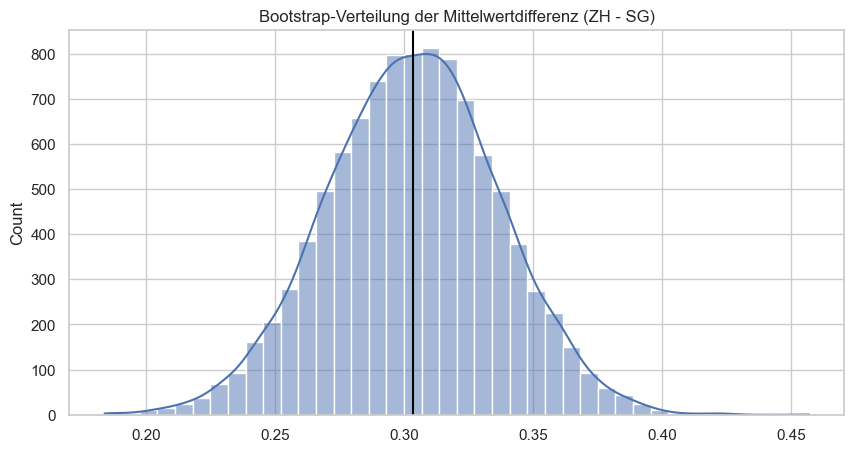

In [19]:
N_BOOT = 10_000

boot_mean = []
boot_median = []

for _ in range(N_BOOT):
    zh_s = np.random.choice(zh, size=len(zh), replace=True)
    sg_s = np.random.choice(sg, size=len(sg), replace=True)

    boot_mean.append(np.mean(zh_s) - np.mean(sg_s))
    boot_median.append(np.median(zh_s) - np.median(sg_s))

boot_mean = np.array(boot_mean)
boot_median = np.array(boot_median)

def ci(x, alpha=0.05):
    return np.quantile(x, [alpha/2, 1-alpha/2])

print("=== Bootstrap CI (Mittelwertdifferenz) ===")
print(ci(boot_mean))

print("\n=== Bootstrap CI (Mediandifferenz) ===")
print(ci(boot_median))

sns.histplot(boot_mean, bins=40, kde=True)
plt.axvline(np.mean(boot_mean), color="black")
plt.title("Bootstrap-Verteilung der Mittelwertdifferenz (ZH - SG)")
plt.show()

### Interpretation & Fazit

Unsere Analyse zeigt:

In unserem Vergleich der Ankunftsverspätungen zwischen dem Zürich Hauptbahnhof und dem Bahnhof St. Gallen zeigt sich, dass die Verspätungen in Zürich im Durchschnitt leicht höher ausfallen. Sowohl parametrische als auch nichtparametrische Tests bestätigen diesen Unterschied statistisch sehr deutlich: Der Welch-t-Test wie auch der Mann–Whitney-U-Test ergeben extrem kleine p-Werte, was darauf hinweist, dass sich die beiden Verteilungen tatsächlich unterscheiden. Dieser Befund wird zudem durch die großen Stichproben unterstützt, da allein die hohe Beobachtungszahl in Zürich dazu führt, dass selbst kleine Abweichungen als signifikant erkannt werden können.

Trotz der klaren Signifikanz bleibt die praktische Relevanz des Unterschieds gering. Die Mittelwertdifferenz beträgt lediglich rund 0.3 Minuten, und die Effektgrößen zeigen dasselbe Bild: Cohen’s d von 0.077 entspricht einem sehr kleinen Effekt, und auch die rank-biseriale Korrelation deutet darauf hin, dass St. Gallen nur einen leichten Vorteil hinsichtlich Pünktlichkeit aufweist. Damit bestätigt sich, dass der Unterschied zwar statistisch robust, aber in seinem Ausmaß gering ist.

Die Bootstrap-Auswertung mit 10’000 Iterationen untermauert dieses Resultat weiter. Die Konfidenzintervalle für Mittelwert- und Medianunterschied liegen vollständig oberhalb von null, was das Vorzeichen und die Richtung des Effekts bestätigt. Besonders wichtig ist dabei, dass Bootstrap-Verfahren die starke Rechtsschiefe der Verspätungsverteilungen berücksichtigen, sodass das Ergebnis nicht von Normalverteilungsannahmen abhängt.

Insgesamt zeigen unsere Analysen, dass Zürich HB tendenziell leicht unpünktlicher ist als St. Gallen, was plausibel ist, da größere Bahnhöfe komplexere Betriebsabläufe aufweisen. Der Unterschied ist klar nachweisbar, aber in seiner absoluten Größe klein. Statistisch betrachtet besteht ein stabiler Effekt; betrieblich gesehen ist dieser jedoch eher moderat und dürfte sich im Alltag nur begrenzt bemerkbar machen.